In [12]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
# from nest import modules, run_tasks
import matplotlib.pyplot as plt
import random
import xml.etree.ElementTree as ET
from collections import OrderedDict
from PIL import Image
import cv2
# from scipy.misc import imresize
from termcolor import colored


In [13]:
from utils.utils import mrmse, rel_mrmse
from train_utils.datasets import pascal_voc_object_categories
from train_utils.datasets import image_transform

In [14]:
# object categories
class_names = pascal_voc_object_categories()
image_size = 448
# image pre-processor
transformer = image_transform(
    image_size = [image_size, image_size],
    augmentation = dict(),
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])

In [15]:
from models.backbone import fc_resnet50
from models.PRM import peak_response_mapping
from utils.prm_utils import prm_visualize

In [16]:
backbone = fc_resnet50(channels=60, pretrained=False)
model = peak_response_mapping(backbone, 
                              enable_peak_stimulation=True, 
                              peak_stimulation='addedmodule5', 
                              sub_pixel_locating_factor=1)
                              
# loaded pre-trained weights
model = nn.DataParallel(model)
state = torch.load('./weights/pascal07.pt')
model.load_state_dict(state['model'])
model = model.module.cuda()

<function PeakResponseMapping._median_filter at 0x000001E362C26DC0>
addedmodule5
enable_peak_stimulation on


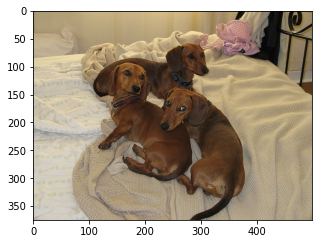

In [17]:
# change the idx to test different samples

idx = 1
raw_img = Image.open('./demo/pascal/sample%d.jpg' % idx).convert('RGB')
input_var = transformer(raw_img).unsqueeze(0).cuda().requires_grad_()
# plot raw image
plt.figure(figsize=(5,5))
plt.imshow(raw_img)

In [18]:
## predict count

model = model.eval()
confidence, density_map, _ = model(input_var, 1)
count_den = F.adaptive_avg_pool2d(density_map, 1).squeeze(2).squeeze(2).detach().cpu().numpy()[0]
density_map = density_map.squeeze().detach().cpu().numpy()
confidence = confidence.cpu().detach().numpy()
confidence[confidence < 0] = 0
confidence = confidence[0]
confidence[confidence > 0] = 1
count = np.round(confidence * count_den)

print('***************************')
print('Object count in the image:')
for index in range(len(class_names)):
    if count[index]:
        print(colored('    [class_idx: %d] %s (%.2f)' % (index, class_names[index], count[index]),'blue'))

posi_cls=[i for i in range(len(class_names)) if count[i]] # index of positive classes in the image

***************************
Object count in the image:
    [class_idx: 11] dog (3.00)


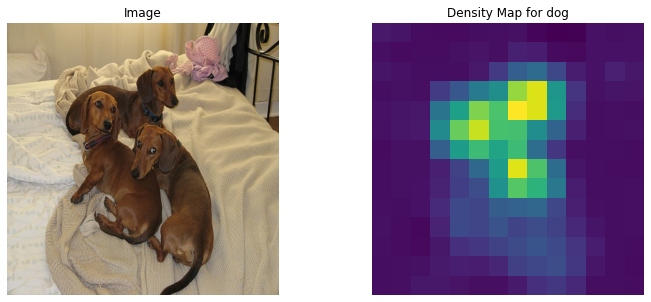

In [19]:
# visualization
f, axarr = plt.subplots(1, 1 + len(posi_cls), figsize=(12, 5))
axarr[0].imshow(np.array(raw_img.resize((image_size, image_size))))
axarr[0].set_title('Image')
axarr[0].axis('off')
for i in range(len(posi_cls)):
    axarr[1 + i].imshow(density_map[posi_cls[i]])
    axarr[1].set_title('Density Map for ' + class_names[posi_cls[i]])
    axarr[1].axis('off')
plt.show()

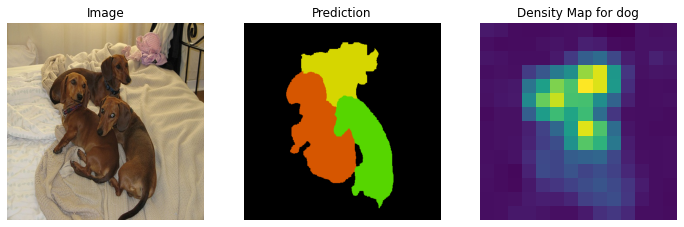

In [20]:
## predict instance segmentation
from utils.utils import rle_decode

model = model.inference()

with open('./demo/pascal/sample%d.json' % idx, 'r') as f:
    proposals_cob = list(map(rle_decode, json.load(f)))

instance_list, _ = model(input_var, 1, peak_threshold=20, 
                                  retrieval_cfg=dict(proposals=proposals_cob,
                                  proposal_count=100, 
                                  param=(0.95, 1e-5, 0.8, 0.2)))
# visualization
if instance_list is None:
    print('No object detected')
else:
    # peak response maps are merged if they select similar proposals
    vis = prm_visualize(instance_list, class_names=class_names)
    f, axarr = plt.subplots(1, 2+len(posi_cls), figsize=(12, 5))
    # axarr[0].imshow(imresize(raw_img, (image_size, image_size), interp='bicubic'))
    axarr[0].imshow(np.array(raw_img.resize((image_size, image_size))))
    axarr[0].set_title('Image')
    axarr[0].axis('off')
    axarr[1].imshow(vis[0])
    axarr[1].set_title('Prediction')
    axarr[1].axis('off')
    for i in range(len(posi_cls)):
        axarr[2+i].imshow(density_map[posi_cls[i]])
        axarr[2].set_title('Density Map for '+class_names[posi_cls[i]])
        axarr[2].axis('off')
    plt.show()
